<a href="https://colab.research.google.com/github/omanshuthapliyal/ML2Coursework/blob/master/Thapliyal_Omanshu_aml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Student Name: 
#ECE 595 Machine Learning II
#Project 4: Adversarial Machine Learning - Student Code

In [2]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

     |████████████████████████████████| 71kB 2.3MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for cleverhans: filename=cleverhans-2.1.0-cp27-none-any.whl size=74866 sha256=a7f35073b1a55423e7ae81c89116bee8799118cbba8439ca132b82bf8c35b855
  Stored in directory: /root/.cache/pip/wheels/5e/d5/ae/5bf57b9265bffd5783c4462a9a7c1c5fd0ebe51db83ff5f586
Successfully built cleverhans


In [0]:
#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

#Part 1: Training a target classifier

In [4]:
#Load MNIST data and normalize to [-1, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = 2*(data_train/255.0 - 0.5)
data_test = 2*(data_test/255.0 - 0.5)
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)
#Reshape training and testing data into 784-dimensional vectors
try:
  d = data_train.shape[1]
  data_train = data_train.reshape((data_train.shape[0], 
                                  d*d))
  data_test = data_test.reshape((data_test.shape[0], 
                               d*d))
except:
  print("training data shape: ", data_train.shape)
  print("testing data shape: ", data_test.shape)
  print("Data was reshaped already")

nClasses = 10

11501568/11490434 [==============================] - 2s 0us/step


##CNN Model

In [0]:
def nnModel():
  model = Sequential()
  model.add(Dense(100,input_dim=data_test.shape[1],
                activation="relu") )
  model.add(BatchNormalization(axis=-1,momentum=0.99))
  model.add(Dense(100, activation="relu", 
                  kernel_initializer = "uniform") )
  model.add(BatchNormalization(axis=-1,momentum=0.99))
  model.add(Dense(nClasses, activation = 'softmax'))  
  return model

In [9]:
# Training model
model = nnModel()
model.compile(loss='categorical_crossentropy',
                  optimizer = "adam", 
                  metrics = ['accuracy'])
print(model.summary())

model_metaData = model.fit(data_train, labels_train,
                           validation_data = (data_test, labels_test), 
                           epochs = 50, batch_size = 256, 
                           shuffle = True, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               78500     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 90,410
Trainable params: 90,010
Non-trainable params: 400
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.

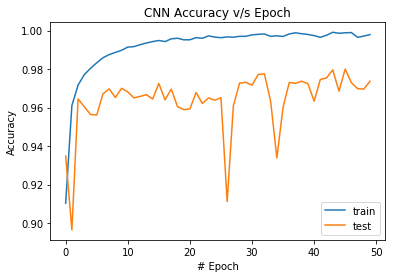

In [10]:
#Plot loss vs epoch
plt.plot(model_metaData.history['acc'])
plt.plot(model_metaData.history['val_acc'])
plt.title('CNN Accuracy v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

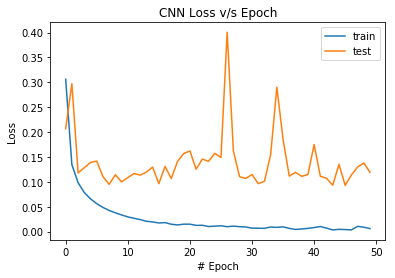

In [11]:
#Plot accuracy vs epoch
plt.plot(model_metaData.history['loss'])
plt.plot(model_metaData.history['val_loss'])
plt.title('CNN Loss v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [12]:
#Print accuracy of classifier on MNIST testing data
scores = model.evaluate(data_test, labels_test)
print("Accuracy: %0.4f%%" %(scores[1]*100) )

10000/10000 [==============================] - 0s 33us/step
Accuracy: 97.3700%


In [0]:
#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(model)

#Part 2: The Fast Gradient Method (FGM)

In [20]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
FGM = FastGradientMethod(wrap, sess = sess)

#Attack parameters
FGM_params = {'eps': 0.25,
              'clip_min': 0.0,
              'clip_max': 1.0}
#Generate adversarial data
FGM_attack_data = FGM.generate_np(data_test, **FGM_params)

#Evaluate accuracy on target classifier 
FGM_adv_scores = model.evaluate(FGM_attack_data, labels_test)
print("Accuracy when subject to FGM Adversarial Attacks: %0.4f%%" %(FGM_adv_scores[1]*100) )

W1105 21:03:38.051784 140163934427008 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/cleverhans/attacks.py:216: calling reduce_max_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W1105 21:03:38.056263 140163934427008 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/cleverhans/attacks.py:218: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1105 21:03:38.062549 140163934427008 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/cleverhans/attacks_tf.py:62: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W1105 21:03:38.069403 140163934427008 deprecation.py:

10000/10000 [==============================] - 1s 54us/step
Accuracy when subject to FGM Adversarial Attacks: 10.9500%


(10000, 784)

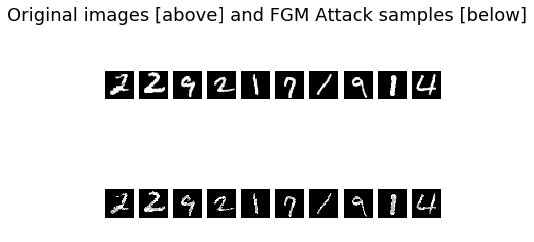

In [68]:
def tenPlotter(test, attack, str1):
  random_ind = np.random.choice(attack.shape[0], 10)
  fig, axs = plt.subplots(2, 10)
  for i in range(10):
    axs[0,i].imshow((test[random_ind[i]].reshape(28, 28)), cmap='gray')
    axs[0,i].axis('off')
    axs[1,i].imshow((attack[random_ind[i]].reshape(28, 28)), cmap='gray')
    axs[1,i].axis('off')
  fig.suptitle('Original images [above] and '+str1+' Attack samples [below]', fontsize=18)

#Show ten original samples and their corresponding adversarial samples
tenPlotter(data_test, FGM_attack_data, 'FGM')

In [43]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Creatin the autoencoder 
auto = autoencoder()
auto.compile(loss = "mean_squared_error",
                   optimizer = "adam" )
#Training parameters
num_epochs = 50
batch_size = 256
# Training the autoencoder using the mean squared error loss and adam optimizer
auto_model_history = auto.fit(data_train, data_train,
                                    validation_data = (data_train,data_train),
                                    epochs = num_epochs,
                                    batch_size = batch_size,
                                    shuffle = True)

W1105 21:21:34.683197 140163934427008 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Train on 60000 samples, validate on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 197us/step - loss: 0.9411 - val_loss: 0.9266
Epoch 2/50
60000/60000 [==============================] - 11s 180us/step - loss: 0.9266 - val_loss: 0.9266
Epoch 3/50
60000/60000 [==============================] - 11s 186us/step - loss: 0.9266 - val_loss: 0.9266
Epoch 4/50
60000/60000 [==============================] - 11s 184us/step - loss: 0.9266 - val_loss: 0.9266
Epoch 5/50
60000/60000 [==============================] - 11s 183us/step - loss: 0.9266 - val_loss: 0.9266
Epoch 6/50
60000/60000 [==============================] - 11s 181us/step - loss: 0.9266 - val_loss: 0.9266
Epoch 7/50
60000/60000 [==============================] - 11s 184us/step - loss: 0.9266 - val_loss: 0.9266
Epoch 8/50
60000/60000 [==============================] - 11s 184us/step - loss: 0.9266 - val_loss: 0.9266
Epoch 9/50
60000/60000 [==============================] - 11s 183us/step - loss: 0.9266 - val_

In [58]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
adversarial_data = FGM.generate_np(data_train, **FGM_params)
# Obtain reconstruction errors on training set and determine a threshold 
autoencoder_reconstruction = auto.predict(adversarial_data)
# Convert error tensor into NumPy array 
error = keras.losses.mean_absolute_error(adversarial_data, 
                                         autoencoder_reconstruction)
error = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
threshold = error.min()
print("Threshold = ", threshold)

# Calculate error of adversarial testing set
autoencoder_reconstruction_testing = auto.predict(FGM_attack_data)
error_test = keras.losses.mean_absolute_error(FGM_attack_data, 
                                              autoencoder_reconstruction_testing)
error_test = error_test.eval(session=sess)

('Threshold = ', 0.67955047)


In [60]:
# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
TPcount = 0
for e in error_test:
  if e > threshold: TPcount += 1

# Print number of true positive samples
print("True positives: ", TPcount)
# Determine false positives on benign testing set
FPcount = data_test.shape[0] - TPcount
print("False positives: ", FPcount)


# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
#FILL THIS IN 
    
# Print number of false positive samples
#FILL THIS IN   

('True positives: ', 10000)
('False positives: ', 0)


#Part 3: Projected Gradient Descent

In [63]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
PGD = MadryEtAl(wrap, sess=sess)

#Attack parameters
PGD_params = {'eps': 0.25,
              'eps_iter': 0.01,
              'nb_iter': 20,
              'clip_min': 0.0,
              'clip_max': 1.0}
#Generate adversarial data
PGD_attack_data = PGD.generate_np(data_test, **PGD_params)

#Evaluate accuracy on target classifier 
PGD_adv_scores = model.evaluate(PGD_attack_data, labels_test)
print("Accuracy when subject to FGM Adversarial Attacks: %0.4f%%" %(PGD_adv_scores[1]*100) )

10000/10000 [==============================] - 2s 201us/step
Accuracy when subject to FGM Adversarial Attacks: 10.6600%


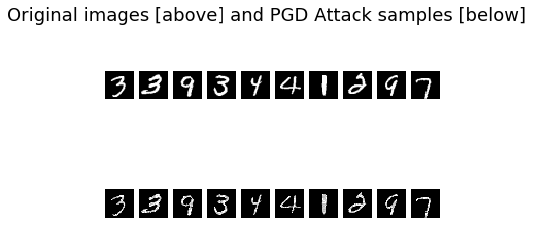

In [69]:
#Show ten original samples and their corresponding adversarial samples
tenPlotter(data_test, PGD_attack_data, 'PGD')

In [0]:
#Implementing the adversarial training defense
#FILL THIS IN

In [0]:
#Using the defense to evaluate the accuracy of the perturbed data
#FILL THIS IN 

#Part 4: Carlini and Wagner Attack

In [74]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
CW = CarliniWagnerL2(wrap, sess = sess)

#Attack parameters
CW_params = {'binary_search_steps': 1,
             'y': None,
             'batch_size': 16,
             'learning_rate': 1.25,
             'initial_const': 10,
             'clip_min': 0.0,
             'clip_max': 1.0}

#Generate adversarial data
CW_attack_data = CW.generate_np(data_test, **CW_params)

#Evaluate accuracy on target classifier 
CW_adv_scores = model.evaluate(CW_attack_data, labels_test)
print("Accuracy when subject to CW Adversarial Attacks: %0.4f%%" %(CW_adv_scores[1]*100) )

W1105 22:40:16.968457 140163934427008 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/cleverhans/attacks_tf.py:725: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W1105 22:40:17.247756 140163934427008 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/cleverhans/attacks.py:909: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.

10000/10000 [==============================] - 2s 241us/step
Accuracy when subject to CW Adversarial Attacks: 0.3000%


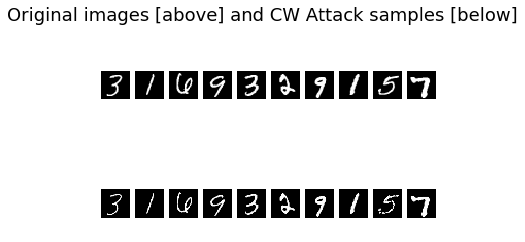

In [75]:
#Show ten original samples and their corresponding adversarial samples
tenPlotter(data_test, CW_attack_data, 'CW')

In [78]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data
CW_attack_data_PCA = pca.transform(CW_attack_data)
# create model for PCA
def pca_model():
    model = Sequential()
    model.add(Dense(100,input_dim=100,
                activation="relu") )
    model.add(BatchNormalization(axis=-1,momentum=0.99))
    model.add(Dense(100, activation="relu") )
    model.add(BatchNormalization(axis=-1,momentum=0.99))
    model.add(Dense(nClasses, activation = 'softmax'))  
    return model

#Create model graph, compile it, and train it using pca_train lables_train 
pca = pca_model()
pca.compile(loss='categorical_crossentropy',
                  optimizer = "adam", 
                  metrics = ['accuracy'])
print(pca.summary())

pca_metaData = pca.fit(pca_train, labels_train,
                       validation_data = (pca_test, labels_test),
                       epochs = 50, batch_size = 256,
                       shuffle = True, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_9 (Batch (None, 100)               400       
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_10 (Batc (None, 100)               400       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1010      
Total params: 22,010
Trainable params: 21,610
Non-trainable params: 400
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.

In [0]:
#Using the defense (and comparing to baseline accuracy)
#FILL THIS IN 

#Part 5: DeepFool 

In [79]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
DF = DeepFool(wrap, sess = sess)
DF_params = {'np_candidate': 10,
             'max_iter': 50,
             'clip_min': 0.0,
             'clip_max': 1.0}

#Generate adversarial data
DF_attack_data = DF.generate_np(data_test, **DF_params)

#Evaluate accuracy on target classifier 
DF_adv_scores = model.evaluate(DF_attack_data, labels_test)
print("Accuracy when subject to DeepFool Adversarial Attacks: %0.4f%%" %(DF_adv_scores[1]*100) )

/usr/local/lib/python2.7/dist-packages/cleverhans/attacks.py:179: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "


10000/10000 [==============================] - 2s 226us/step
Accuracy when subject to DeepFool Adversarial Attacks: 3.8000%


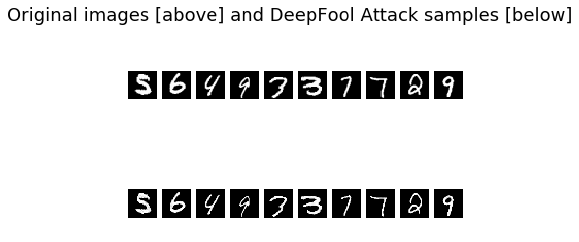

In [80]:
#Show ten original samples and their corresponding adversarial samples
tenPlotter(data_test, DF_attack_data, 'DeepFool')

In [0]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = deepfool.generate_np(data_train, **fgm_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])

#Create and train DAE graph
#FILL THIS IN

In [0]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
#FILL THIS IN

#Evaluate accuracy of FGM samples after denoising 
#FILL THIS IN

In [0]:
#Show ten samples of adversarial samples after denoising
#FILL THIS IN